In [1]:
import pandas as pd

food_orders = pd.read_csv("food_orders_new_delhi.csv")
print(food_orders.head())

   Order ID Customer ID Restaurant ID  Order Date and Time  \
0         1       C8270         R2924  2024-02-01 01:11:52   
1         2       C1860         R2054  2024-02-02 22:11:04   
2         3       C6390         R2870  2024-01-31 05:54:35   
3         4       C6191         R2642  2024-01-16 22:52:49   
4         5       C6734         R2799  2024-01-29 01:19:30   

  Delivery Date and Time  Order Value  Delivery Fee    Payment Method  \
0    2024-02-01 02:39:52         1914             0       Credit Card   
1    2024-02-02 22:46:04          986            40    Digital Wallet   
2    2024-01-31 06:52:35          937            30  Cash on Delivery   
3    2024-01-16 23:38:49         1463            50  Cash on Delivery   
4    2024-01-29 02:48:30         1992            30  Cash on Delivery   

  Discounts and Offers  Commission Fee  Payment Processing Fee  \
0            5% on App             150                      47   
1                  10%             198                  

In [2]:
print(food_orders.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Order ID                1000 non-null   int64 
 1   Customer ID             1000 non-null   object
 2   Restaurant ID           1000 non-null   object
 3   Order Date and Time     1000 non-null   object
 4   Delivery Date and Time  1000 non-null   object
 5   Order Value             1000 non-null   int64 
 6   Delivery Fee            1000 non-null   int64 
 7   Payment Method          1000 non-null   object
 8   Discounts and Offers    815 non-null    object
 9   Commission Fee          1000 non-null   int64 
 10  Payment Processing Fee  1000 non-null   int64 
 11  Refunds/Chargebacks     1000 non-null   int64 
dtypes: int64(6), object(6)
memory usage: 93.9+ KB
None


In [3]:
from datetime import datetime

# convert date and time columns to datetime
food_orders['Order Date and Time'] = pd.to_datetime(food_orders['Order Date and Time'])
food_orders['Delivery Date and Time'] = pd.to_datetime(food_orders['Delivery Date and Time'])

# Function to extract numeric values from the 'Discounts and Offers' string
def extract_discount(discount_str):
    if isinstance(discount_str, str):
        if 'off' in discount_str:
            if '%' in discount_str:
                # Percentage off
                return float(discount_str.split('%')[0])
            else:
                # Fixed amount off
                return float(discount_str.split(' ')[0])
        else:
            # No discount
            return 0.0
    else:
        # Handle non-string values, treat as no discount
        return 0.0

# Apply the function to create a new 'Discount Percentage' column
food_orders['Discount Percentage'] = food_orders['Discounts and Offers'].apply(lambda x: extract_discount(x))

# Calculate the discount amount based on the order value and discount type
food_orders['Discount Amount'] = food_orders.apply(lambda x: (x['Order Value'] * x['Discount Percentage'] / 100)
                                                   if '%' in str(x['Discounts and Offers'])
                                                   else x['Discount Percentage'], axis=1)

print(food_orders[['Order Value', 'Discounts and Offers', 'Discount Percentage', 'Discount Amount']])


     Order Value Discounts and Offers  Discount Percentage  Discount Amount
0           1914            5% on App                  0.0              0.0
1            986                  10%                  0.0              0.0
2            937         15% New User                  0.0              0.0
3           1463                  NaN                  0.0              0.0
4           1992         50 off Promo                 50.0             50.0
..           ...                  ...                  ...              ...
995          825            5% on App                  0.0              0.0
996         1627                  NaN                  0.0              0.0
997          553                  NaN                  0.0              0.0
998         1414         15% New User                  0.0              0.0
999         1657         15% New User                  0.0              0.0

[1000 rows x 4 columns]


In [4]:
# calculate total costs and revenue per order
food_orders['Total Costs'] = food_orders['Delivery Fee'] + food_orders['Payment Processing Fee'] + food_orders['Discount Amount']
food_orders['Revenue'] = food_orders['Commission Fee']
food_orders['Profit'] = food_orders['Revenue'] - food_orders['Total Costs']

# aggregate data to get overall metrics
total_orders = food_orders.shape[0]
total_revenue = food_orders['Revenue'].sum()
total_costs = food_orders['Total Costs'].sum()
total_profit = food_orders['Profit'].sum()

overall_metrics = {
    "Total Orders": total_orders,
    "Total Revenue": total_revenue,
    "Total Costs": total_costs,
    "Total Profit": total_profit
}

print(overall_metrics)

{'Total Orders': 1000, 'Total Revenue': 126990, 'Total Costs': 68502.0, 'Total Profit': 58488.0}


Matplotlib is building the font cache; this may take a moment.


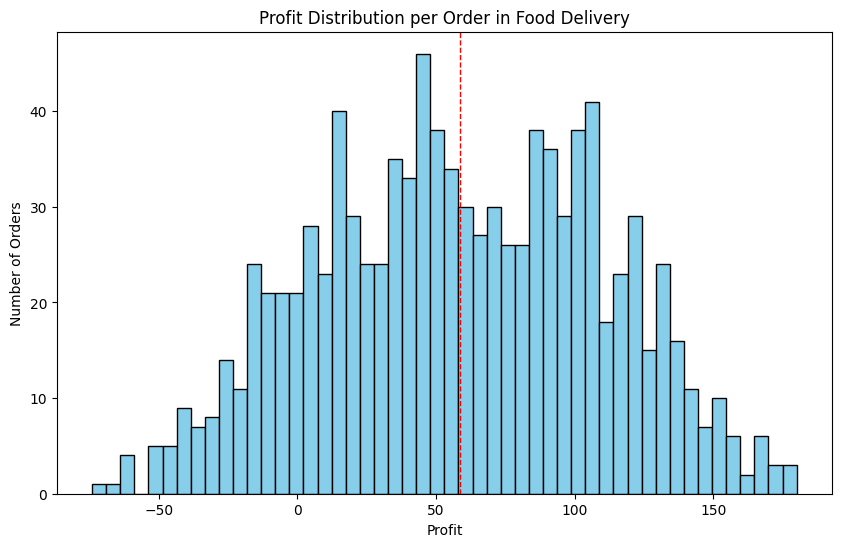

In [6]:
import matplotlib.pyplot as plt

# histogram of profits per order
plt.figure(figsize=(10, 6))
plt.hist(food_orders['Profit'], bins=50, color='skyblue', edgecolor='black')
plt.title('Profit Distribution per Order in Food Delivery')
plt.xlabel('Profit')
plt.ylabel('Number of Orders')
plt.axvline(food_orders['Profit'].mean(), color='red', linestyle='dashed', linewidth=1)
plt.show()

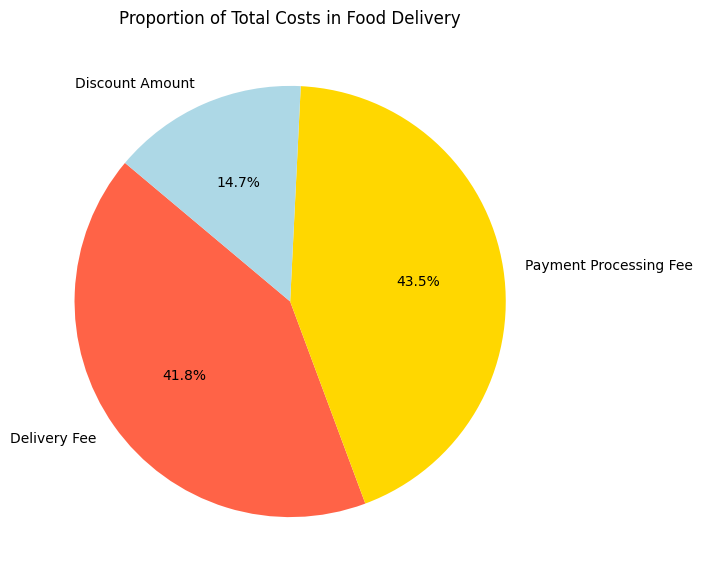

In [7]:
# pie chart for the proportion of total costs
costs_breakdown = food_orders[['Delivery Fee', 'Payment Processing Fee', 'Discount Amount']].sum()
plt.figure(figsize=(7, 7))
plt.pie(costs_breakdown, labels=costs_breakdown.index, autopct='%1.1f%%', startangle=140, colors=['tomato', 'gold', 'lightblue'])
plt.title('Proportion of Total Costs in Food Delivery')
plt.show()

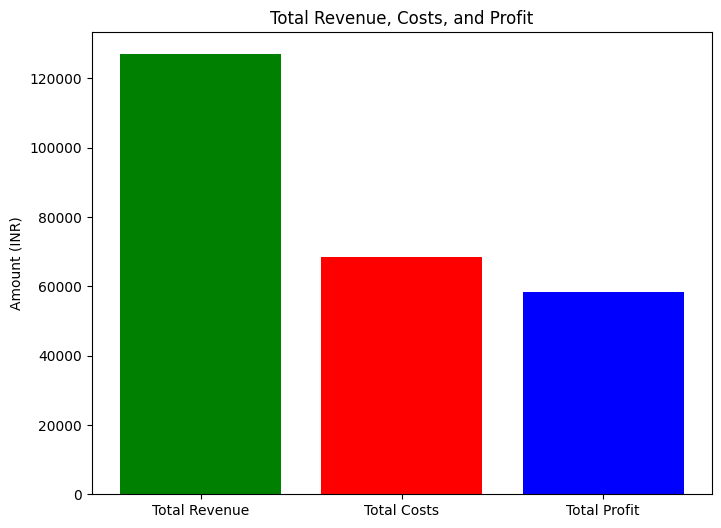

In [8]:
# bar chart for total revenue, costs, and profit
totals = ['Total Revenue', 'Total Costs', 'Total Profit']
values = [total_revenue, total_costs, total_profit]

plt.figure(figsize=(8, 6))
plt.bar(totals, values, color=['green', 'red', 'blue'])
plt.title('Total Revenue, Costs, and Profit')
plt.ylabel('Amount (INR)')
plt.show()

In [10]:
# Filter the dataset for profitable orders
profitable_orders = food_orders[food_orders['Profit'] > 0].copy()

# Calculate the average commission percentage for profitable orders
profitable_orders.loc[:, 'Commission Percentage'] = (profitable_orders['Commission Fee'] / profitable_orders['Order Value']) * 100

# Calculate the average discount percentage for profitable orders
profitable_orders.loc[:, 'Effective Discount Percentage'] = (profitable_orders['Discount Amount'] / profitable_orders['Order Value']) * 100

# Calculate the new averages
new_avg_commission_percentage = profitable_orders['Commission Percentage'].mean()
new_avg_discount_percentage = profitable_orders['Effective Discount Percentage'].mean()

print(new_avg_commission_percentage, new_avg_discount_percentage)


21.406103809508405 1.1466046178001041


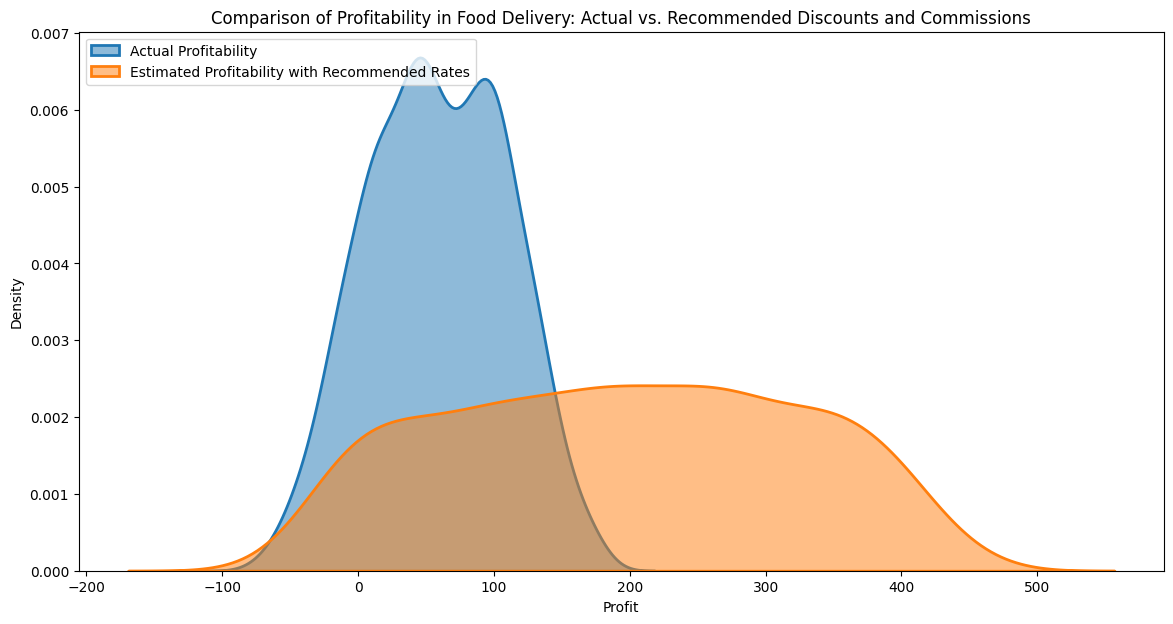

In [12]:
# simulate profitability with recommended discounts and commissions
recommended_commission_percentage = 30.0  # 30%
recommended_discount_percentage = 6.0    # 6%

# calculate the simulated commission fee and discount amount using recommended percentages
food_orders['Simulated Commission Fee'] = food_orders['Order Value'] * (recommended_commission_percentage / 100)
food_orders['Simulated Discount Amount'] = food_orders['Order Value'] * (recommended_discount_percentage / 100)

# recalculate total costs and profit with simulated values
food_orders['Simulated Total Costs'] = (food_orders['Delivery Fee'] +
                                        food_orders['Payment Processing Fee'] +
                                        food_orders['Simulated Discount Amount'])

food_orders['Simulated Profit'] = (food_orders['Simulated Commission Fee'] -
                                   food_orders['Simulated Total Costs'])

# visualizing the comparison
import seaborn as sns

plt.figure(figsize=(14, 7))

# actual profitability
sns.kdeplot(food_orders['Profit'], label='Actual Profitability', fill=True, alpha=0.5, linewidth=2)

# simulated profitability
sns.kdeplot(food_orders['Simulated Profit'], label='Estimated Profitability with Recommended Rates', fill=True, alpha=0.5, linewidth=2)

plt.title('Comparison of Profitability in Food Delivery: Actual vs. Recommended Discounts and Commissions')
plt.xlabel('Profit')
plt.ylabel('Density')
plt.legend(loc='upper left')
plt.show()